In [300]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from utils import lists
from tqdm import tqdm
from scipy.stats import norm
import scipy
import matplotlib.cm as cm


# Read data file

In [301]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
chn = [2048,2048]
header, events, timing = lists.lstRead(FILE_PATH)
coin = [True, True, False, False, False, False, False, False]
zdrop = True
data = np.array(lists.getCoins(events,coin,zdrop))

In [302]:

############ Util functions ############

def make_palette(K, cmap=plt.cm.rainbow):
    # Define colormap and sample K evenly spaced colors
    indices = np.linspace(0, 1, K)
    return cmap(indices)

def sample_fraction(X, phi, y, fraction=0.1, random_seed=None):
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Set random seed for reproducibility if provided
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Calculate the number of samples
    n_samples = int(len(X) * fraction)
    
    # Randomly select indices to sample
    sampled_indices = np.random.choice(len(X), n_samples, replace=False)
    
    # Return the sampled data
    X_sampled = X[sampled_indices]
    y_sampled = y[sampled_indices]
    phi_sampled = phi[sampled_indices]
    return X_sampled, phi_sampled, y_sampled

def plot_predictions(x, y, y_pred, model, size=1, fill=False):
    p = model.params()
    colors = make_palette(p['K'])
    
    sort_index = np.argsort(x.flatten())
    x = x[sort_index]
    y = y[sort_index]
    y_pred = y_pred[sort_index]
    beta = p['beta']
    
    plt.scatter(x, y, c='grey', s=size, alpha=0.1)
    plt.ylabel('ToF (channel)')
    plt.xlabel('Energy (channel)')
    for k in tqdm(range(p['K'])):
        color = colors[k]
        plt.plot(x, y_pred[:,k], color=color, alpha=0.8, label=f'Component {k}')
        # fill one standard deviation (95% interval)
        if fill:
                plt.fill_between(x, 
                                y_pred[:, k] - np.sqrt(beta[k]), 
                                y_pred[:, k] + np.sqrt(beta[k]), 
                                color=color,
                                alpha=0.3)
    plt.legend(loc='upper right')
    plt.show()

def plot_responsibilities(x, m):
    p = m.params()
    gamma_nk = p['gamma_nk']
    colors = make_palette(p['K'])

    for k in range(gamma_nk.shape[1]):
        plt.plot(x, gamma_nk[:,k], color=colors[k], alpha=0.3)
    plt.ylabel("Probability")
    plt.xlabel("Data axis")
    plt.title("Component probability/responsibility")
    plt.show()

In [344]:
class MixtureLinearRegression():
    """Implementation of Mixture of Linear Regressions.

    Parameters
    ----------
    K : int
        Number of components.

    beta : float
        Noise precision hyper parameter

    iterations : int
        How many iterations the EM algorithms should go 

    bias : bool
        Flag for including or excluding bias term
    """    
    def __init__(self, K, beta, iterations, bias=False, beta_reg=1e-4, epsilon=1e-7, lam=1e-4, random_state=None):
        # Number of components
        self.K = K
        # Initialize component variance
        self.beta_k = np.full(self.K, beta)
        # Weights for linreg (D x K), initialize all to 0
        self.W = np.zeros(K)
        # Responsibility, initiated when training (N x K)
        self.gamma_nk = 0
        # Mixture weights (K,)
        self.pi = np.zeros((1, self.K)) + 1/(K)
        # Number of iterations
        self.iterations = iterations
        # Bias flag
        self.bias = bias
        # Regularization terms TODO: should be tuned
        self.lam = lam
        self.epsilon = epsilon
        self.beta_reg = beta_reg
        # Random state
        self.random_state = random_state

    def params(self):
        params = { 'K': self.K,
                  'beta': self.beta_k,
                  'W': self.W,
                  'pi': self.pi,
                  'gamma_nk': self.gamma_nk
                  }
        return params

    def _add_bias(self, X):
        N = X.shape[0]
        return np.concatenate((np.ones((N, 1)), X), axis=1)

    def _e_step(self, X, y):
        """ Side effects: self.gamma_nk """
        # Calculate log likelihoods
        means = X @ self.W
        log_probs_k = -(np.log(2 * np.pi) + np.log(self.beta_k) + (y.reshape(-1, 1) - means)**2) / (2*self.beta_k)

        # Add log of mixing coefficients + regularization
        log_weighted_probs_k = np.log(self.pi + self.epsilon) + log_probs_k

        # Use log-sum-exp trick for numerical stability
        log_norm = scipy.special.logsumexp(log_weighted_probs_k, axis=1, keepdims=True)

        log_likelihood = np.sum(log_norm)
        
        # Get responsibilities (gamma_nk)
        self.gamma_nk = np.exp(log_weighted_probs_k - log_norm)
        return log_likelihood

    def _m_step(self, X, y):
        """ Side effects: self.W and self.beta_k """
        # Update mixture weights
        self.pi = self.gamma_nk.mean(axis=0) 
        self.pi = self.pi/self.pi.sum()
        for k in range(self.K):
            # Update W matrix (without diag(gamma_nk[:,k]))
            self.W[:, k] = np.linalg.solve((self.gamma_nk[:,k] + self.lam) * X.T @ X, (self.gamma_nk[:,k] + self.lam) * X.T @ y).reshape(-1)

        # Update beta
        self.beta_k = np.mean(self.gamma_nk * (y - (X @ self.W))**2, axis=0) + self.beta_reg

    def _expectation_maximization(self, X, y, tol=1e-4):
        prev_log_likelihood = -np.inf
        
        for i in tqdm(range(self.iterations)):
            # E-step
            log_likelihood = self._e_step(X, y)
            # M-step
            self._m_step(X, y)            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < tol:
                print(f"Converged after {i+1} iterations.")
                return

            prev_log_likelihood = log_likelihood

        print(f"Stopped after {self.iterations} iterations.")

    def train(self, X, y):
        if self.bias:
            # Add bias feature
            X = self._add_bias(X)
        # Initialize variables
        _, D = X.shape
        # Initialize regression weights
        if self.random_state:
            random_state = np.random.RandomState(self.random_state)
            self.W = random_state.uniform(low=y.min(), high=y.max(), size=(D, self.K))
        else: 
            self.W = np.random.uniform(low=y.min(), high=y.max(), size=(D, self.K))
        # Update mixture parameters via EM algorithm
        self._expectation_maximization(X, y)

    def step(self, X, y):
        """ Do one iteration of EM, can be used to plot model iteratively """
        if self.bias:
            X = self._add_bias(X)
        # if W uninitialized
        if (self.W == 0).all():
            _, D = X.shape
            if self.random_state:
                random_state = np.random.RandomState(self.random_state)
                self.W = random_state.uniform(low=y.min(), high=y.max(), size=(D, self.K))
            else: 
                self.W = np.random.uniform(low=y.min(), high=y.max(), size=(D, self.K))
        # E-step
        _ = self._e_step(X, y)
        # M-step
        self._m_step(X, y)     

    def predict_probs(self, X):
        if self.bias:
            X = self._add_bias(X)
        # Compute mean predictions for each component
        likelihoods = norm.pdf(X @ self.W, loc=0, scale=np.sqrt(1/self.beta))

        # Weight the likelihoods by the mixing coefficients
        weighted_likelihoods = likelihoods * self.pi

        # Normalize to get probabilities for each component
        probabilities = weighted_likelihoods / (weighted_likelihoods.sum(axis=1, keepdims=True) + self.epsilon)

        return probabilities

    def predict(self, X):
        if self.bias:
            X = self._add_bias(X)
        # Prediction will be the deterministic means of the Linear Regressions
        return X @ self.W


### Do naive feature engineering and train model on a small sample on the data

In [324]:
# Feature engineering function (x^exponent) (WILL NEED OTHER FEATURES)
def Phi(x, exponents=[1]):
    phi = np.empty((x.shape[0], len(exponents)))
    for i, b in enumerate(exponents):
        if b < 0:
            phi[:,i] = (1/np.power(x, -b).flatten())
        else:
            phi[:,i] = np.power(x, b).flatten()
    return phi

X = np.array(data[0]).astype(int)
y = data[1].astype(int).reshape((-1,1))
phi = Phi(X, [-1/2])
# Sample a fraction of data (will take too much time / memory otherwise)
# X, phi, y = sample_fraction(X, phi, y, fraction=1)

100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Stopped after 3 iterations.
{'K': 5, 'beta': array([6.36691328e+03, 9.78311125e+00, 4.38983942e+00, 2.19778922e+00,
       4.08007378e+03]), 'W': array([[ 1100.66395065,   821.72935094,   576.31477546,   741.56492393,
          339.47777916],
       [-4807.84991315,  6138.69045816,  6027.01442029,  1529.70350072,
         1006.38095768]]), 'pi': array([8.47559857e-01, 2.80963009e-04, 1.29748028e-04, 3.58398251e-05,
       1.51993592e-01]), 'gamma_nk': array([[9.99999951e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.93408779e-08],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.71971312e-10],
       [9.96919046e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.08095385e-03],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.14930052e-11],
       [1.92373065e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.07626935e-01],
       [9.99684929e-01, 0.00000000e+00, 0.00000

100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


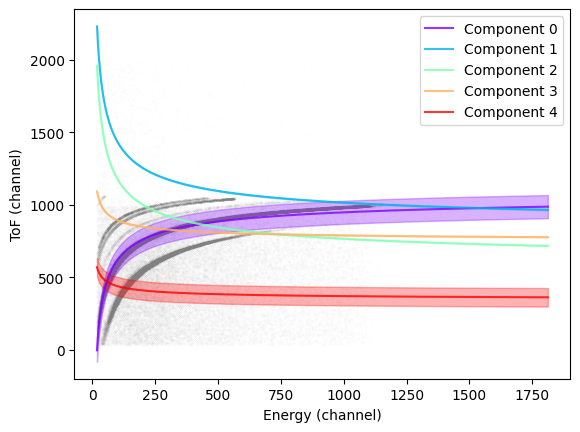

In [347]:
mlr = MixtureLinearRegression(K=5, beta=1/y.var(), iterations=3, bias=True, random_state=42)
mlr.train(phi, y)
y_pred = mlr.predict(phi)
print(mlr.params())
plot_predictions(X, y, y_pred, mlr, size=0.01, fill=True)

100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


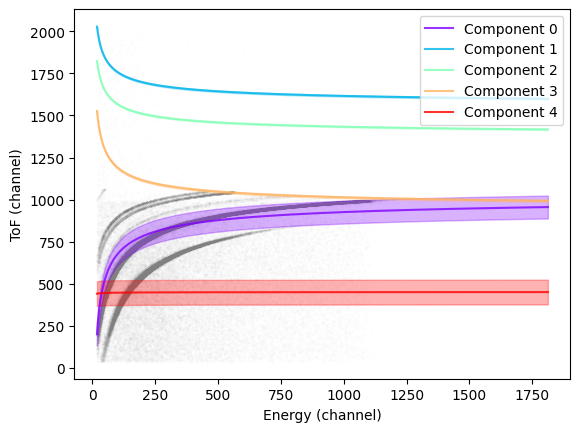

100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


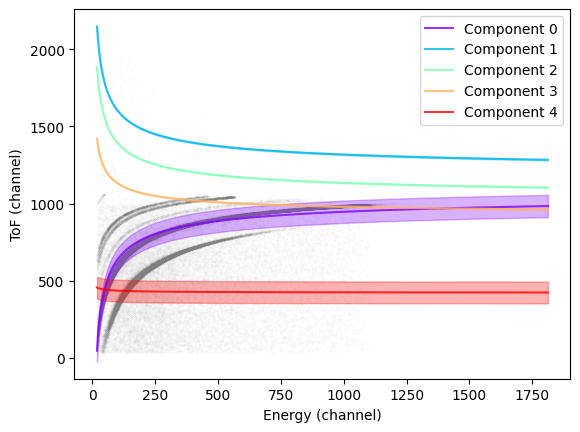

100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


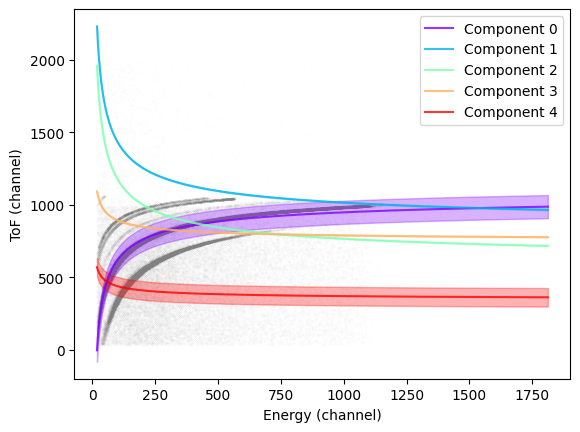

100%|██████████| 5/5 [00:00<00:00, 11.01it/s]


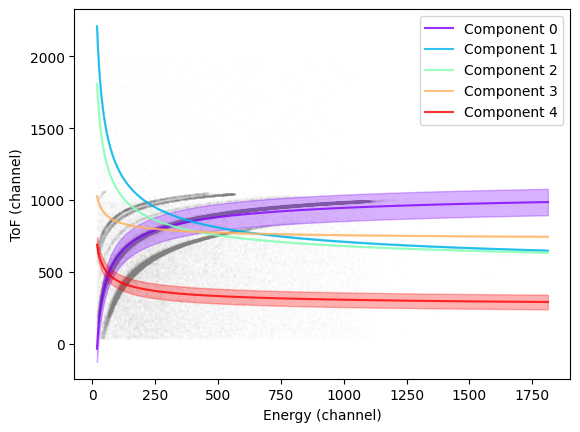

100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


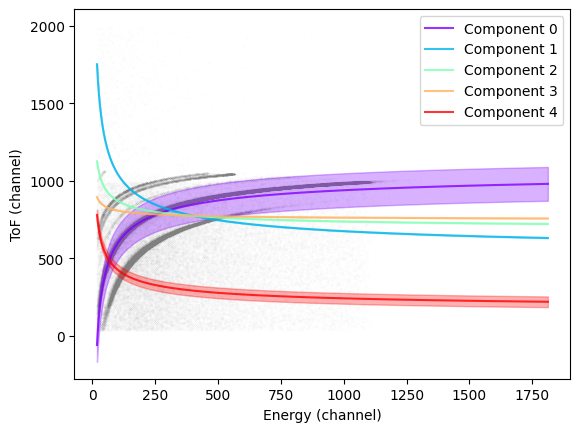

100%|██████████| 5/5 [00:00<00:00,  9.09it/s]


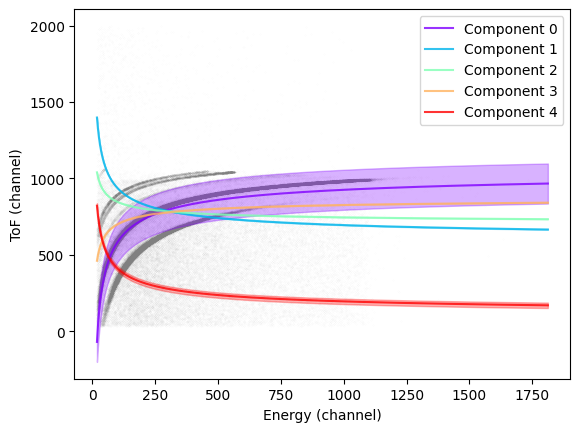

100%|██████████| 5/5 [00:00<00:00, 14.66it/s]


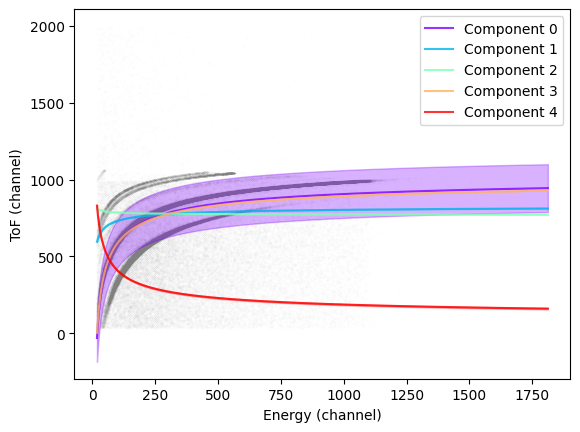

100%|██████████| 5/5 [00:00<00:00,  9.62it/s]


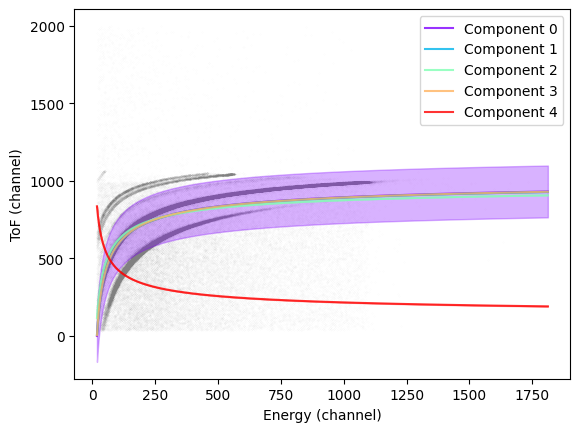

100%|██████████| 5/5 [00:00<00:00, 13.79it/s]


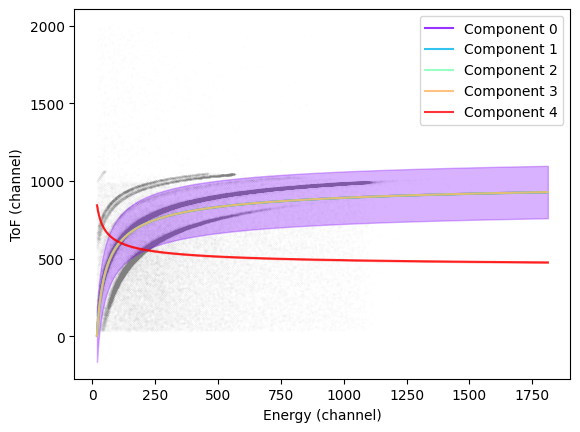

100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


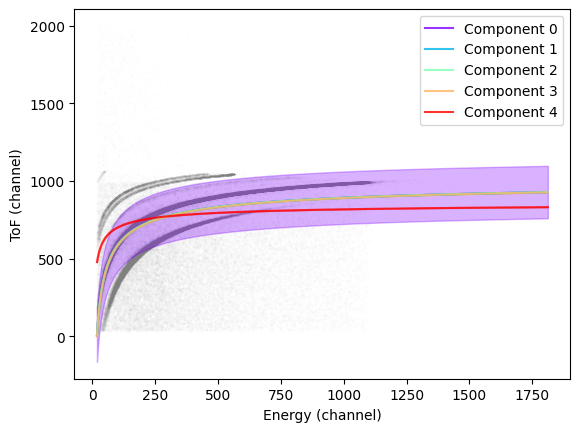

In [342]:
mlr = MixtureLinearRegression(K=5, beta=1/y.var(), iterations=0, bias=True, random_state=42)
iterations = 10
for i in range(iterations):
    mlr.step(phi, y)
    y_pred = mlr.predict(phi)
    plot_predictions(X, y, y_pred, mlr, size=0.01, fill=True)

# Testing mixed linreg

### Define data
Linear data, with an interval where the derivative and spread increases

In [ ]:
line = np.linspace(start=0, stop=99, num=100, dtype=int)
y_data = np.empty(shape=(len(line)))
for x in line:
    n = x + np.random.normal(loc=0, scale=5)
    if x > 25 and x < 75:
        n = 5*x + np.random.normal(loc=0, scale=25) + 200
    y_data[x] = n

(100,)
(100,)


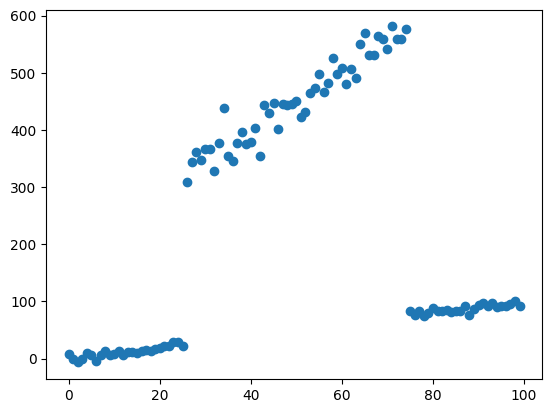

In [ ]:
print(line.shape)
print(y_data.shape)
plt.scatter(line, y_data)

#### We'd expect the mixture of linear regression to capture both lines. If bias, then perfectly, if no bias, then two lines where one goes through the two lower, and one which goes through the upper

## Mixture with bias

 40%|████      | 2/5 [00:00<00:00, 1941.36it/s]


Converged after 3 iterations.
{'K': 2, 'beta': array([1.00000000e-04, 4.19178691e+04]), 'W': array([[165.58891879, 165.58891879],
       [  1.62319931,   1.62319931]]), 'pi': array([0., 1.]), 'gamma_nk': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

100%|██████████| 2/2 [00:00<00:00, 1715.11it/s]


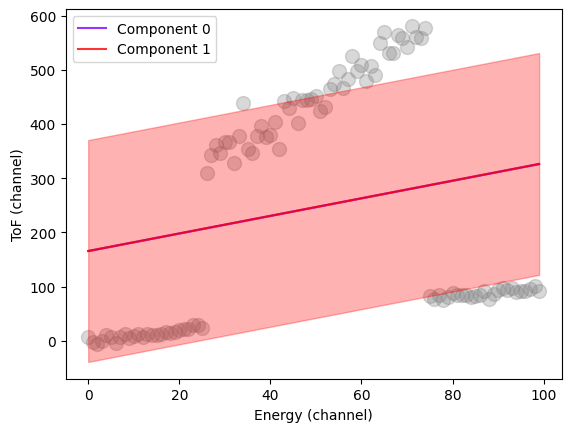

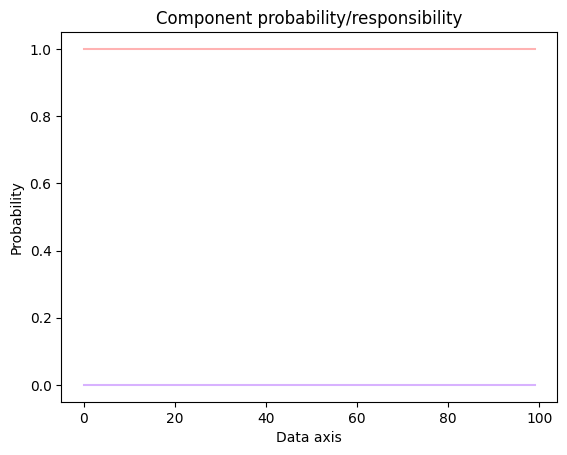

In [ ]:
x = Phi(line, [1])
y_data = y_data.reshape((-1, 1))
m = MixtureLinearRegression(K=2, beta=1/y_data.var(), iterations=5, bias=True)
m.train(x, y_data)
print(m.params())
y_pred = m.predict(x)
plot_predictions(x[:,0], y_data, y_pred, m, size=100, fill=True)
plot_responsibilities(x[:,0], m)

## Mixture without bias

 30%|███       | 3/10 [00:00<00:00, 906.88it/s]


Converged after 4 iterations.
{'K': 2, 'beta': array([1.00000000e-04, 4.88761321e+04]), 'W': array([[4.11951467, 4.11951467]]), 'pi': array([0., 1.]), 'gamma_nk': array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
    

100%|██████████| 2/2 [00:00<?, ?it/s]


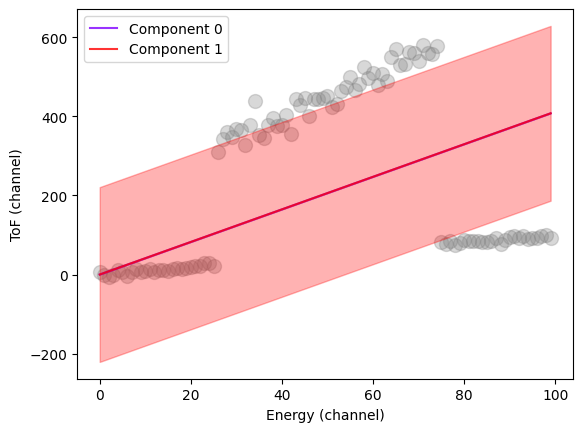

In [ ]:
m = MixtureLinearRegression(K=2, beta=1/5, iterations=10, bias=False)
x = Phi(line, [1])
y_data = y_data.reshape((-1, 1))
m.train(x, y_data)
y_pred = m.predict(x)
print(m.params())
plot_predictions(x[:,0], y_data, y_pred, m, size=100, fill=True)

### Works as expected. Now we gotta find good features for ToF-ERDA and optimize the class (the N x N matrices are not fast). Regularization terms and other hyperparameters can be optimized